# Chron.jl standalone age-depth model with simple Gaussian age constraints

This Jupyter notebook executes an age-depth model for Naples using [Chron.jl](https://github.com/brenhinkeller/Chron.jl). For more information on the model, see [github.com/brenhinkeller/Chron.jl](https://github.com/brenhinkeller/Chron.jl) and [doi.org/10.17605/osf.io/TQX3F](https://doi.org/10.17605/osf.io/TQX3F). All age data inputs are summarized in Table SM1 of Anttila et al. (2023). Age constraints incorporated via lithostratigraphic correlation with El Capitan are noted below. 
***

## Load required Julia packages

In [1]:
# Load (and install if necessary) the Chron.jl package
try
    using Chron
catch
    using Pkg
    Pkg.add("Chron")
    using Chron
end

using Statistics, StatsBase, DelimitedFiles, SpecialFunctions
using Plots; gr(); default(fmt = :png)

In [2]:
### Input the number of samples incorporated in model (must match below)
nSamples = 16 #includes 

# Make an instance of a ChronSection object for nSamples
smpl = NewChronAgeData(nSamples)
smpl.Name          = ("EA1902-16.6","EA1902-12.34","EA1902-12.0","EA1902-11.5","EA1902-11.73","EA1902-9.2","F1916_24.9","M1806","M1805","M1808","M1804_6.5", "Knott upper bound","EAGC2006","EAGC2008","F1917-33.7","F1917-0.7") # Names
smpl.Age           = [10.572,11.34,11.33,11.591,11.808,13.07,14.32,17.42,17.53,18.14,18.19,8.989,13.907,14.297,15.498,17.276] # Measured ages
smpl.Age_sigma     = [0.110744,0.22676,0.2266,0.23182,0.06331,0.261,0.2884,0.34838,0.35062,0.3627,0.3638,.84,.044,.019,.026,.027]/2 # Measured 1-σ uncertainties
smpl.Height[:]     = [289,284,283.7,283.2,283.43,280.9,211,139,54,0,10.5,318,253,230,201,163] # Depths below surface should be negative
smpl.Height_sigma[:]  = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1.5,1.5,1.5,1.5] # Usually assume little or no sample height uncertainty
smpl.Age_Sidedness[:] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Path = "Output_Naples/" # Where do you want output files to be stored

smpl.Age_Unit = "Ma"; # Unit of measurement for ages
smpl.Height_Unit = "m"; # Unit of measurement for Height and Height_sigma

Note that smpl.Height *must* increase with increasing stratigraphic height -- i.e., stratigraphically younger samples must be more positive. For this reason, it is convenient to represent depths below surface as negative numbers.

***
## Configure and run stratigraphic model, no hiatuses

To run the stratigraphic MCMC model, we call the `StratMetropolis` function, which uses the Gaussian mean age and standard deviation set in `smpl.Age` and `smpl.Age_sigma`

Generating stratigraphic age-depth model...
Burn-in: 31820000 steps


Burn-in... 100%|█████████████████████████████████████████| Time: 0:00:54


Collecting... 100%|██████████████████████████████████████| Time: 0:02:43


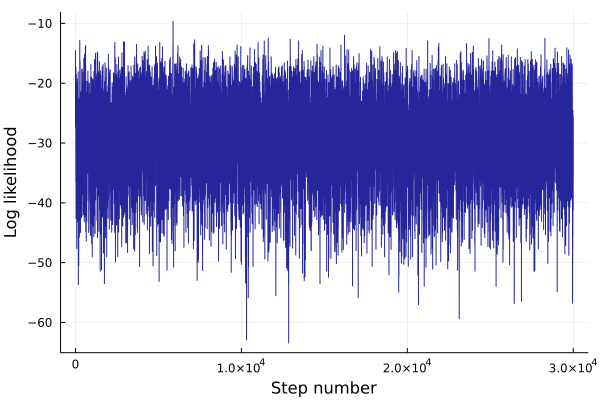

In [3]:
# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If in doubt, you can probably leave these parameters as-is
config.resolution = 0.2 # Same units as sample height. Smaller is slower!
config.bounding = 0.5 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolis(smpl, config)

# Write the results to file
run(`mkdir -p $(smpl.Path)`) # Make sure that the path exists
writedlm(smpl.Path*"agedist.csv", agedist, ',') # Stationary distribution of the age-depth model
writedlm(smpl.Path*"height.csv", mdl.Height, ',') # Stratigraphic heights corresponding to each row of agedist
writedlm(smpl.Path*"age.csv", mdl.Age, ',') # Mean age of resulting model
writedlm(smpl.Path*"age_025CI.csv", mdl.Age_025CI, ',') # 2.5% confidence interval of resulting model
writedlm(smpl.Path*"age_975CI.csv", mdl.Age_975CI, ',') # 97.5% confidence interval of resulting model
writedlm(smpl.Path*"lldist.csv", lldist, ',') # Log likelihood distribution (to check for stationarity)

# Plot the log likelihood to make sure we're converged (n.b burnin isn't recorded)
hdl = plot(lldist,xlabel="Step number",ylabel="Log likelihood",label="",line=(0.85,:darkblue))
savefig(hdl,smpl.Path*"lldist.pdf")
display(hdl)

The most important output of this process is `agedist`, which contains the full stationary distribution of the age-depth model. 
***
## Plot results

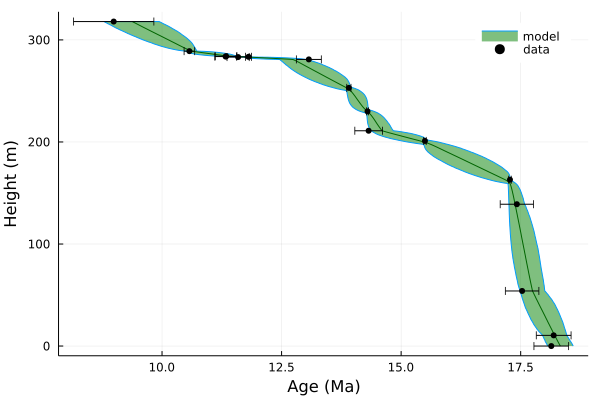

In [4]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(round(Int,minimum(mdl.Height)),0.5,:green), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:darkgreen, label="", fg_color_legend=:white) # Center line
t = smpl.Age_Sidedness .== 0 # Two-sided constraints (plot in black)
plot!(hdl, smpl.Age, smpl.Height, xerror=smpl.Age_sigma*2,label="data",seriestype=:scatter,color=:black)
t = smpl.Age_Sidedness .== 1 # Minimum ages (plot in cyan)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(smpl.Age[t]-smpl.Age_025CI[t],zeros(count(t))),label="",seriestype=:scatter,color=:black,msc=:black)
any(t) && zip(smpl.Age[t], smpl.Age[t].+nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:black)
t = smpl.Age_Sidedness .== -1 # Maximum ages (plot in orange)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(zeros(count(t)),smpl.Age_975CI[t]-smpl.Age[t]),label="",seriestype=:scatter,color=:orange,msc=:orange)
any(t) && zip(smpl.Age[t], smpl.Age[t].-nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:orange)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")

savefig(hdl,smpl.Path*"AgeDepthModel.svg")
savefig(hdl,smpl.Path*"AgeDepthModel.pdf")
display(hdl)

In [5]:
#solve for age of data heights

height = range(0,stop=400)

single_age_at_height = linterp1s(mdl.Height,mdl.Age,height)
writedlm(smpl.Path*"Naples_age_at_height1.csv", single_age_at_height, ',')

  0.884127 seconds (1.22 M allocations: 1.259 GiB, 12.92% gc time, 14.43% compilation time)


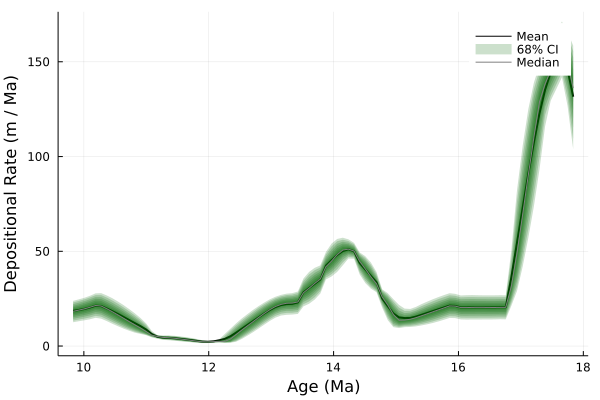

In [7]:
# Set bin width and spacing
binwidth = round(nanrange(mdl.Age)/10,sigdigits=1) # Can also set manually, commented out below
#binwidth = .5 # Same units as smpl.Age
binoverlap = 10
ages = collect(minimum(mdl.Age):binwidth/binoverlap:maximum(mdl.Age))
bincenters = ages[1+Int(binoverlap/2):end-Int(binoverlap/2)]
spacing = binoverlap

# Calculate rates for the stratigraphy of each markov chain step
dhdt_dist = Array{Float64}(undef, length(ages)-binoverlap, config.nsteps)
@time for i=1:config.nsteps
    heights = linterp1(reverse(agedist[:,i]), reverse(mdl.Height), ages)
    dhdt_dist[:,i] .= abs.(heights[1:end-spacing] - heights[spacing+1:end]) ./ binwidth
end

# Find mean and 1-sigma (68%) CI
dhdt = nanmean(dhdt_dist,dim=2)
dhdt_50p = nanmedian(dhdt_dist,dim=2)
dhdt_16p = nanpctile(dhdt_dist,15.865,dim=2) # Minus 1-sigma (15.865th percentile)
dhdt_84p = nanpctile(dhdt_dist,84.135,dim=2) # Plus 1-sigma (84.135th percentile)
# Other confidence intervals (10:10:50)
dhdt_20p = nanpctile(dhdt_dist,20,dim=2)
dhdt_80p = nanpctile(dhdt_dist,80,dim=2)
dhdt_25p = nanpctile(dhdt_dist,25,dim=2)
dhdt_75p = nanpctile(dhdt_dist,75,dim=2)
dhdt_30p = nanpctile(dhdt_dist,30,dim=2)
dhdt_70p = nanpctile(dhdt_dist,70,dim=2)
dhdt_35p = nanpctile(dhdt_dist,35,dim=2)
dhdt_65p = nanpctile(dhdt_dist,65,dim=2)
dhdt_40p = nanpctile(dhdt_dist,40,dim=2)
dhdt_60p = nanpctile(dhdt_dist,60,dim=2)
dhdt_45p = nanpctile(dhdt_dist,45,dim=2)
dhdt_55p = nanpctile(dhdt_dist,55,dim=2)

# Plot results
hdl = plot(bincenters,dhdt, label="Mean", color=:black, linewidth=2)
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_16p; reverse(dhdt_84p)], fill=(0,0.2,:darkgreen), linealpha=0, label="68% CI")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_20p; reverse(dhdt_80p)], fill=(0,0.2,:darkgreen), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_25p; reverse(dhdt_75p)], fill=(0,0.2,:darkgreen), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_30p; reverse(dhdt_70p)], fill=(0,0.2,:darkgreen), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_35p; reverse(dhdt_65p)], fill=(0,0.2,:darkgreen), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_40p; reverse(dhdt_60p)], fill=(0,0.2,:darkgreen), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_45p; reverse(dhdt_55p)], fill=(0,0.2,:darkgreen), linealpha=0, label="")
plot!(hdl,bincenters,dhdt_50p, label="Median", color=:grey, linewidth=1)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Depositional Rate ($(smpl.Height_Unit) / $(smpl.Age_Unit))", fg_color_legend=:white)
savefig(hdl,smpl.Path*"DepositionRateModelCI_Naples.pdf")
display(hdl)

writedlm(smpl.Path*"Naplesbincenters.csv", bincenters, ',')
writedlm(smpl.Path*"Naplesdhdt.csv", dhdt, ',')
writedlm(smpl.Path*"Naplesdhdt_50.csv", dhdt_50p, ',')
writedlm(smpl.Path*"Naplesdhdt_16.csv", dhdt_16p, ',')
writedlm(smpl.Path*"Naplesdhdt_84.csv", dhdt_84p, ',')

In [8]:
#solve for age of data heights

height = [0.539083558
3.126684636
12.83018868
16.06469003
17.35849057
20.59299191
24.47439353
27.70889488
30.94339623
38.05929919
42.58760108
47.11590296
49.05660377
51.64420485
54.23180593
58.76010782
60.05390836
61.34770889
65.22911051
67.16981132
68.46361186
78.1671159
80.75471698
81.40161725
82.04851752
83.34231806
83.34231806
83.34231806
83.34231806
83.35664336
85.92991914
86.57681941
90.45822102
91.75202156
96.92722372
98.04195804
98.22102426
100.8086253
100.8391608
100.8391608
101.5384615
102.1024259
103.3962264
105.9838275
107.277628
109.2183288
110.5121294
112.4528302
113.4265734
115.6873315
116.9811321
119.5687332
124.097035
125.3146853
127.3315364
130.5660377
134.4474394
137.6819407
140.916442
144.7978437
148.032345
150.4895105
151.2668464
151.9137466
189.4339623
194.6091644
197.8290214
197.8436658
199.7843666
200.359955
200.7649044
201.0781671
201.1698538
203.0188679
204.4094488
205.928009
206.2533693
207.7502812
209.2688414
210.1347709
210.2812148
212.3059618
213.3692722
214.3307087
214.6630728
215.5244755
215.5244755
216.2542182
216.6037736
218.3802025
218.5444744
219.8987627
221.7789757
222.1259843
223.4420697
225.0134771
225.9730034
230.4274466
232.3509561
236.0967379
237.9020979
237.9020979
238.3239595
238.5983827
240.5390836
242.7784027
243.7735849
246.5241845
247.6549865
248.5489314
250.8894879
251.1811024
251.5860517
252.1832884
252.5984252
252.8301887
252.9021372
253.5095613
253.8132733
254.1239892
254.4206974
254.7244094
254.7708895
255.1293588
255.4177898
255.5343082
256.0404949
256.7115903
256.7115903
256.7491564
257.1541057
257.6602925
257.9640045
258.0053908
258.5714286
258.6522911
258.6522911
259.0776153
259.583802
260.0899888
260.2797203
260.2797203
260.5929919
260.5929919
260.6974128
261.2035996
261.8110236
261.8867925
262.3172103
262.5336927
263.6332958
263.8274933
264.0382452
264.4743935
264.7469066
265.2530934
265.7592801
266.2654668
266.7716535
267.0619946
267.0619946
267.3790776
267.7088949
267.8852643
268.3914511
268.9988751
269.6495957
269.9100112
270.8211474
270.9433962
271.5902965
271.5902965
272.0359955
272.1372328
272.5421822
272.884097
273.048369
273.4533183
273.5309973
273.5545557
274.3644544
274.4656918
274.8247978
275.0731159
275.2755906
275.5793026
275.984252
275.984252
276.1185984
276.1867267
276.591676
276.7654987
276.8953881
277.4015748
277.5028121
277.8065242
277.9077615
278.0592992
278.6164229
279.0213723
279.3250844
279.3530997
279.5275591
279.7300337
280.2362205
280.3374578
280.5399325
280.5399325
280.6411699
280.6469003
280.6469003
280.8436445
281.0461192
281.1473566
281.2938005
281.2938005
281.3498313
281.6535433
281.7547807
282.0584927
282.0584927
282.5876011
283.0708661
284.2857143
284.5283019
284.791901
285.6017998
286.8166479
287.115903
289.3475816
289.703504
290.056243
290.359955
290.359955
290.663667
290.8661417
291.4735658
292.9380054
293.5849057
293.5995501
293.8461538
293.8461538
294.5106862
296.0292463
296.1725067
296.8391451
297.9527559
298.7412587
298.7412587
298.7412587
298.863892
299.8762655
300.0539084
300.9898763
303.2884097
304.431946
305.3430821
306.1529809
306.4335664
306.4335664
306.5229111
306.9628796
308.8863892
310
310.4043127
312.027972
312.027972
312.4296963
312.9919137
314.0494938
316.1754781
317.5202156
317.6223776
320.1078167
321.43982
323.3423181
323.4645669
325.3146853
325.3146853
325.3146853
325.8942632
326.8053993
327.2237197
327.4128234
327.7165354
327.9190101
329.8113208
330.8548931
332.87964
334.904387
334.9865229
336.9272237
337.0303712
339.1563555
340.1617251
343.3962264
347.277628
351.1590296
354.393531
356.9811321
360.8625337
363.7762238
363.7762238
364.097035
367.3315364
371.212938
374.4474394
376.3636364
378.328841
381.5633423]

single_age_at_height = linterp1s(mdl.Height,mdl.Age,height)
writedlm(smpl.Path*"Naples_age_at_height_TOC.csv", single_age_at_height, ',')